# Data Ingest

This section reads in the training, weather, holiday and metadata for all Sites across datasets

In [5]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sqlalchemy import create_engine
from utilities import convert_to_date, convert_to_int, convert_to_float, timestamp_to_int
from utilities import get_year, get_month, string_to_timestamp, timestamp_to_string
from utilities import meter_desc_mapper, activity_mapper, holidays_mapper, log_value
from sklearn.preprocessing import LabelEncoder
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [35]:
holidays = pd.read_csv('data/power-laws-detecting-anomalies-in-usage-holidays.csv', sep=';')
weather = pd.read_csv('data/power-laws-detecting-anomalies-in-usage-weather.csv', sep=';')
consumption = pd.read_csv('data/power-laws-detecting-anomalies-in-usage-training-data.csv', sep=';')
metadata = pd.read_csv('data/power-laws-detecting-anomalies-in-usage-metadata.csv', sep=';')

Data filtered for Site 38

In [36]:
holidays_38 = holidays[holidays['site_id'] == '038']
weather_38 = weather[weather['site_id'] == 38]
meters = ['38_10106', '38_10107', '38_10108', '38_10109', '38_10110', '38_10111', '38_10112']
consumption_38 = consumption[consumption['meter_id'].isin(meters)]
metadata_38 = metadata[metadata['meter_id'].isin(meters)]

# Data Wrangle
This section merges the holidays, weather, consumption and metadata for Site 38

In [37]:
holidays_38.groupby('site_id').count()

,Date,Holiday
site_id,,
038,99,99


In [38]:
weather_38.groupby('site_id').count()
weather_38['Date'] = weather_38['Timestamp'].apply(convert_to_date)

In [39]:
weather_holiday = pd.merge(holidays_38, weather_38,
                           on='Date', how='outer')
weather_holiday = weather_holiday.drop_duplicates(subset='Timestamp', keep="last")
(weather_holiday.groupby('Timestamp', as_index=False)['Date']
   .agg({'count': 'count'})
   .query('count > 1'))
years = ['2012', '2013', '2014', '2015', '2016', '2017']
weather_holiday['Year'] = weather_holiday['Date'].apply(get_year)
weather_holiday['Month'] = weather_holiday['Date'].apply(get_month)
weather_holiday = weather_holiday[weather_holiday['Year'].isin(years)]
weather_holiday.drop('site_id_y', inplace=True, axis=1)
weather_holiday.groupby('Year').count()

,Date,Holiday,site_id_x,Timestamp,Temperature,Distance,Month
Year,,,,,,,
2012,8535,264,264,8535,8535,8535,8535
2013,8646,263,263,8646,8646,8646,8646
2014,8420,247,247,8420,8420,8420,8420
2015,8572,246,246,8572,8572,8572,8572
2016,8710,245,245,8710,8710,8710,8710
2017,8271,218,218,8271,8271,8271,8271


In [40]:
consumption_metadata = pd.merge(consumption_38, metadata_38,
                                on='meter_id', how='outer')

In [41]:
weather_holiday_dataset = pd.read_csv('data/power-laws-weather-holiday.csv')

In [42]:
consumption_metadata['Date'] = consumption_metadata['Timestamp'].apply(convert_to_date)
consumption_metadata['Year'] = consumption_metadata['Date'].apply(get_year)

In [43]:
consumption_metadata['Timestamp'] = consumption_metadata['Timestamp'].apply(string_to_timestamp)
consumption_metadata = consumption_metadata[consumption_metadata['Year'].isin(years)]
consumption_metadata.head(10)

,meter_id,Timestamp,Values,site_id,meter_description,units,surface,activity,Date,Year
16,38_10107,2012-01-01 17:30:00,-74622.0,038,laboratory,kWh,NaN,laboratory,2012-01-01,2012
17,38_10107,2012-01-01 19:00:00,-74622.0,038,laboratory,kWh,NaN,laboratory,2012-01-01,2012
18,38_10107,2012-01-01 21:45:00,-74622.0,038,laboratory,kWh,NaN,laboratory,2012-01-01,2012
19,38_10107,2012-01-01 23:15:00,-74622.0,038,laboratory,kWh,NaN,laboratory,2012-01-01,2012
20,38_10107,2012-01-02 03:15:00,-74622.0,038,laboratory,kWh,NaN,laboratory,2012-01-01,2012
21,38_10107,2012-01-02 16:00:00,-74614.0,038,laboratory,kWh,NaN,laboratory,2012-01-02,2012
22,38_10107,2012-01-03 00:15:00,-74614.0,038,laboratory,kWh,NaN,laboratory,2012-01-02,2012
23,38_10107,2012-01-03 01:00:00,-74614.0,038,laboratory,kWh,NaN,laboratory,2012-01-02,2012
24,38_10107,2012-01-03 01:15:00,-74614.0,038,laboratory,kWh,NaN,laboratory,2012-01-02,2012
25,38_10107,2012-01-03 12:00:00,-74597.0,038,laboratory,kWh,NaN,laboratory,2012-01-03,2012


In [44]:
consumption_metadata['Timestamp'] = consumption_metadata['Timestamp'].apply(timestamp_to_string)

In [45]:
consumption_metadata_null = consumption_metadata[consumption_metadata['Values'].isna()]
consumption_metadata_null.count()

meter_id             61490
Timestamp            61490
Values                   0
site_id              61490
meter_description    61490
units                61490
surface                  0
activity             61490
Date                 61490
Year                 61490
dtype: int64

### Merge Consumption, Metadata, Weather, Holiday

In [46]:
consumption_weather = pd.merge(consumption_metadata, weather_holiday_dataset,
                               on='Timestamp', how='inner')
# consumption_weather = consumption_weather[consumption_weather['Year_x'] == '2014']
columns = ['site_id_x', 'Date_y', 'Year_y', 'surface']
consumption_weather.drop(columns, inplace=True, axis=1)
consumption_weather.count()

meter_id             1424528
Timestamp            1424528
Values               1364879
site_id              1424528
meter_description    1424528
units                1424528
activity             1424528
Date_x               1424528
Year_x               1424528
Holiday                41524
Temperature          1424528
Distance             1424528
Month                1424528
dtype: int64

In [47]:
consumption_weather.head(5)

,meter_id,Timestamp,Values,site_id,meter_description,units,activity,Date_x,Year_x,Holiday,Temperature,Distance,Month
0,38_10107,2012-01-01 17:30:00,-74622.0,038,laboratory,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1
1,38_10108,2012-01-01 17:30:00,3994762.0,038,laboratory,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1
2,38_10109,2012-01-01 17:30:00,1474846.0,038,lighting,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1
3,38_10106,2012-01-01 17:30:00,889166.0,038,guardhouse,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1
4,38_10110,2012-01-01 17:30:00,11088862.0,038,other,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1


### Convert data to numeric values

In [48]:
consumption_weather['site_id'] = 38
consumption_weather['Year_x'] = consumption_weather['Year_x'].apply(convert_to_int)
consumption_weather['meter_id'] = consumption_weather['meter_id'].apply(convert_to_int)
consumption_weather['Timestamp'] = consumption_weather['Timestamp'].apply(string_to_timestamp)
consumption_weather['Date_x'] = consumption_weather['Date_x'].apply(string_to_timestamp)
consumption_weather['Timestamp_numeric'] = consumption_weather['Timestamp'].apply(timestamp_to_int)
consumption_weather['Date_numeric'] = consumption_weather['Date_x'].apply(timestamp_to_int)

In [25]:
consumption_weather.head(5)

,meter_id,Timestamp,Values,site_id,meter_description,units,activity,Date_x,Year_x,Holiday,Temperature,Distance,Month,Timestamp_numeric,Date_numeric
0,3810107,2012-01-01 17:30:00,-74622.0,38,laboratory,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1,1325457000,1325394000
1,3810108,2012-01-01 17:30:00,3994762.0,38,laboratory,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1,1325457000,1325394000
2,3810109,2012-01-01 17:30:00,1474846.0,38,lighting,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1,1325457000,1325394000
3,3810106,2012-01-01 17:30:00,889166.0,38,guardhouse,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1,1325457000,1325394000
4,3810110,2012-01-01 17:30:00,11088862.0,38,other,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1,1325457000,1325394000


In [26]:
consumption_weather.isna().sum()

meter_id                   0
Timestamp                  0
Values                 59649
site_id                    0
meter_description          0
units                      0
activity                   0
Date_x                     0
Year_x                     0
Holiday              1383004
Temperature                0
Distance                   0
Month                      0
Timestamp_numeric          0
Date_numeric               0
dtype: int64

In [27]:
consumption_values_null = consumption_weather[consumption_weather['Values'].isna()]
consumption_values_null.groupby("meter_id").count()

,Timestamp,Values,site_id,meter_description,units,activity,Date_x,Year_x,Holiday,Temperature,Distance,Month,Timestamp_numeric,Date_numeric
meter_id,,,,,,,,,,,,,,
3810106,5179,0,5179,5179,5179,5179,5179,5179,195,5179,5179,5179,5179,5179
3810107,26565,0,26565,26565,26565,26565,26565,26565,845,26565,26565,26565,26565,26565
3810108,4521,0,4521,4521,4521,4521,4521,4521,195,4521,4521,4521,4521,4521
3810109,4523,0,4523,4523,4523,4523,4523,4523,196,4523,4523,4523,4523,4523
3810110,4634,0,4634,4634,4634,4634,4634,4634,196,4634,4634,4634,4634,4634
3810111,7308,0,7308,7308,7308,7308,7308,7308,268,7308,7308,7308,7308,7308
3810112,6919,0,6919,6919,6919,6919,6919,6919,268,6919,6919,6919,6919,6919


In [50]:
consumption_weather['meter_description_numeric'] = consumption_weather['meter_description'].apply(meter_desc_mapper)
consumption_weather['activity_numeric'] = consumption_weather['activity'].apply(activity_mapper)
consumption_weather['Holiday_numeric'] = consumption_weather['Holiday'].apply(holidays_mapper)

In [51]:
consumption_weather["Holiday"].fillna("", inplace=True)
consumption_weather["Holiday_numeric"].fillna(0, inplace=True)
consumption_weather["Values"].fillna(0, inplace=True)

In [91]:
consumption_weather_negative_values = consumption_weather[consumption_weather['Values'] < 0]

In [92]:
consumption_weather_negative_values.count()

meter_id                     82524
Timestamp                    82524
Values                       82524
site_id                      82524
meter_description            82524
units                        82524
activity                     82524
Date_x                       82524
Year_x                       82524
Holiday                       2488
Temperature                  82524
Distance                     82524
Month                        82524
Timestamp_numeric            82524
Date_numeric                 82524
meter_description_numeric    82524
activity_numeric             82524
Holiday_numeric              82524
dtype: int64

In [52]:
consumption_weather.to_csv("data/power-laws-energy-consumption-dataset.csv", index=False)

In [2]:
consumption_weather = pd.read_csv("data/power-laws-energy-consumption-dataset.csv")

In [7]:
consumption_weather_non_negative_values = consumption_weather[consumption_weather['Values'] > 0]
consumption_weather_non_negative_values.count()

meter_id                     1282355
Timestamp                    1282355
Values                       1282355
site_id                      1282355
meter_description            1282355
units                        1282355
activity                     1282355
Date_x                       1282355
Year_x                       1282355
Holiday                        36873
Temperature                  1282355
Distance                     1282355
Month                        1282355
Timestamp_numeric            1282355
Date_numeric                 1282355
meter_description_numeric    1282355
activity_numeric             1282355
Holiday_numeric              1282355
dtype: int64

In [8]:
consumption_weather_non_negative_values ['Energy'] = consumption_weather_non_negative_values['Values'].apply(log_value) 

In [9]:
consumption_weather_non_negative_values.to_csv("data/power-laws-energy-consumption-non-negative-dataset.csv", index=False)

In [10]:
consumption_weather_non_negative_values.head(5)

,meter_id,Timestamp,Values,site_id,meter_description,units,activity,Date_x,Year_x,Holiday,Temperature,Distance,Month,Timestamp_numeric,Date_numeric,meter_description_numeric,activity_numeric,Holiday_numeric,Energy
1,3810108,2012-01-01 17:30:00,3.994762e+06,38,laboratory,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1,1325457000,1325394000,1,1,3.0,15.200495
2,3810109,2012-01-01 17:30:00,1.474846e+06,38,lighting,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1,1325457000,1325394000,2,1,3.0,14.204064
3,3810106,2012-01-01 17:30:00,8.891660e+05,38,guardhouse,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1,1325457000,1325394000,3,1,3.0,13.698039
4,3810110,2012-01-01 17:30:00,1.108886e+07,38,other,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1,1325457000,1325394000,4,1,3.0,16.221452
5,3810111,2012-01-01 17:30:00,4.474658e+05,38,cold group,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1,1325457000,1325394000,5,1,3.0,13.011355


# Predict Energy consumption

In [11]:
consumption_weather = pd.read_csv("data/power-laws-energy-consumption-non-negative-dataset.csv")

In [26]:
consumption_weather_numeric = consumption_weather[['meter_id', 'Energy', 'Timestamp_numeric', 'Temperature', 'Distance', 'meter_description_numeric', 'activity_numeric', 'Holiday_numeric']]

In [27]:
energy_features = consumption_weather[['meter_id', 'Timestamp_numeric', 'Temperature', 'Distance', 'meter_description_numeric', 'activity_numeric', 'Holiday_numeric']]
energy_labels = consumption_weather[['Energy']]

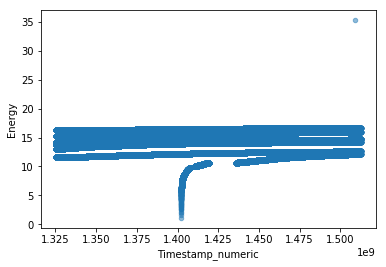

In [29]:
# scatter_matrix(energy_features, alpha=0.2, figsize=(18,18), diagonal='kde')
# plt.show()
consumption_weather_numeric.plot(kind="scatter", x="Timestamp_numeric", y="Energy", alpha=0.5)
#plt.savefig('scatter.png')
#scatter_matrix(dataset_numeric, alpha=0.2, figsize=(25,25), diagonal='kde')
plt.show()

In [28]:
corr_matrix = consumption_weather_numeric.corr()
corr_matrix["Energy"].sort_values(ascending=False)

Energy                       1.000000e+00
Timestamp_numeric            4.005157e-02
Distance                     7.671412e-14
Holiday_numeric             -1.290619e-03
Temperature                 -9.053599e-03
meter_id                    -1.027891e-01
meter_description_numeric   -2.420229e-01
activity_numeric                      NaN
Name: Energy, dtype: float64

In [30]:
X_train, X_test, y_train, y_test = train_test_split(energy_features, energy_labels, test_size=0.2)

In [31]:
model = LinearRegression()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print('Linear Regression model')
print('Mean Squared Error: %0.3f' % mse(expected, predicted))
print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))

Linear Regression model
Mean Squared Error: 2.314
Coefficient of Determination: 0.077


In [32]:
model = Ridge(alpha=0.1)
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print('Ridge model')
print('Mean Squared Error: %0.3f' % mse(expected, predicted))
print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))

Ridge model
Mean Squared Error: 2.314
Coefficient of Determination: 0.077


In [33]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print('Random Forest model')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Random Forest model
Mean squared error = 0.001
R2 score = 1.000
